In [4]:
import fcsfiles as fcs # Small one-man repo, likely has bugs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.rcParams["svg.fonttype"] = "none"

In [2]:
def get_corr(files, clip=False, dir="../data/2024_09_05-FCSandImg/", all_corr=False):
    '''
    Function to extract correlation from a list of fcs files. 
    Returns times, average of all correlations, and number of traces used (usually more than one per file).
    '''
    if type(files) != list:
        files = [files]
    n_total = 0
    for f in files:
        data = fcs.ConfoCor3Fcs(f'{dir}{f}')
        n_samp = len(data['FcsData']['FcsEntry'])
        n_total += n_samp
        for i in range(n_samp):
            if i==0 and n_total==n_samp: # This should only happen once.
                times_corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,0]
                sum_corr = np.zeros(len(times_corr))
            corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
            if clip:
                corr = corr - corr[clip] + 1
            if len(corr) == 0: # This had to be added because of extra entry in atto488. Probably the average done in ZEN. 
                n_total -= 1
                continue
            sum_corr += corr
    mean_corr = sum_corr/n_total
    return times_corr, mean_corr, n_total

In [3]:
def f_fitK(tau, N, tauD, k):
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5

/tmp/ipykernel_115190/601778994.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


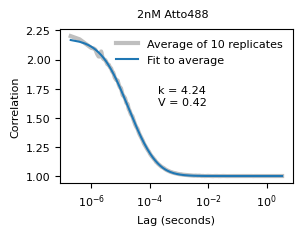

In [34]:
# Calibrate size of focal volume using concentration of atto488
atto2nM = 'atto488_2nM_blocked.fcs'
times_corr, mean_corr, n_total = get_corr(atto2nM, dir="../data/2024_09_10-NiceImgs/")
fit = curve_fit(f_fitK, times_corr, mean_corr, p0=None)
popt, pcov = fit
title = f"2nM Atto488"
fig, axs = plt.subplots(1, 1, figsize=(3,2))
fig.suptitle(title, fontsize=8)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_fitK(times_corr, *popt), 
         label="Fit to average")
axs.legend(fontsize=8, frameon=False)
axs.set_ylabel("Correlation", fontsize=8)
axs.set_xlabel("Lag (seconds)", fontsize=8)
axs.tick_params(labelsize=8)
fig.text(.45,.5,s=f"k = {round(popt[2],2)} \nV = {round(popt[0]/2,2)}", fontsize=8)
plt.savefig("../figures/fit488.svg")
V = 0.42

Ap4 :	 alpha = 0.687
Ap4 :	 alpha = 0.674
Ap5 :	 alpha = 0.674
Ap5 :	 alpha = 0.673
best average alpha for Ap: 0.6771596411252975


(-1.0, 1.0)

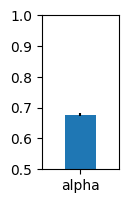

In [35]:
# Find ideal subdiffusivity parameter, alpha. 
Ap4 = ["Ap4_1nuc_unpolarized.fcs", "Ap4_1nuc_polarized.fcs"]
Ap5 = ["Ap5_1nuc_unpolarized.fcs", "Ap5_moreYeast.fcs"]

ap_best = Ap4 + Ap5 # Ap6: ApBem1-GFP is excluded because its FCS curves look pretty bad and its apparent concentration too high for FCS. 

# allow alpha parameter to be fit
def f_fitAlpha(tau, N, tauD, alpha):
    k = 4.2
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5

alphas = []
for probe in ap_best:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135)
    popt, pcov = curve_fit(f_fitAlpha, times_corr[10:135], mean_corr[10:135], bounds=([0,0,0.4],[100,100,1]))
    N = popt[0]
    C = N/V
    print(probe.split("_")[0], ":\t alpha =", round(popt[2],3))
    alphas.append(popt[2])
print(f"best average alpha for Ap: {np.mean(alphas)}")
fig, ax = plt.subplots(figsize=(1,2))#, dpi=600)
ax.bar("alpha", np.mean(alphas))
ax.errorbar("alpha", np.mean(alphas), yerr=np.std(alphas), color="black")
plt.ylim(0.5, 1)
plt.xlim(-1,1)

In [36]:
def f_anomalousAp(tau, N, tauD):
    k = 4.2
    alpha = 0.68
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5

Ap4 : 53.359 nM


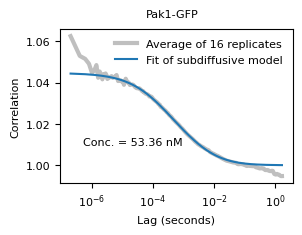

In [37]:
probe = Ap4
times_corr, mean_corr, n_total = get_corr(probe, clip=135) # clip at frame 135 such that autocorrelation persisting past 
popt, pcov = curve_fit(f_anomalousAp, times_corr[10:135], mean_corr[10:135], bounds=(0,100)) # Do not use extremely short-time AC for fit because this includes triplet state signal.
N = popt[0]
C = N/V
print(f"{probe[0][:3]} : {round(C, 3)} nM")
title = "Pak1-GFP"
fig, axs = plt.subplots(1, 1, figsize=(3,2))#, dpi=600)
fig.suptitle(title, fontsize=8)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_anomalousAp(times_corr, popt[0], popt[1]), 
         label=f"Fit of subdiffusive model")
axs.legend(fontsize=8, frameon=False)
axs.set_ylabel("Correlation", fontsize=8)
axs.set_xlabel("Lag (seconds)", fontsize=8)
axs.tick_params(labelsize=8)
fig.text(.2,.3,s=f"Conc. = {round(C, 2)} nM", fontsize=8)
#plt.savefig("../figures/FCS_PakGFP.svg")

Ap5 : 22.879 nM


Text(0.3, 0.3, 'Conc. = 22.88 nM')

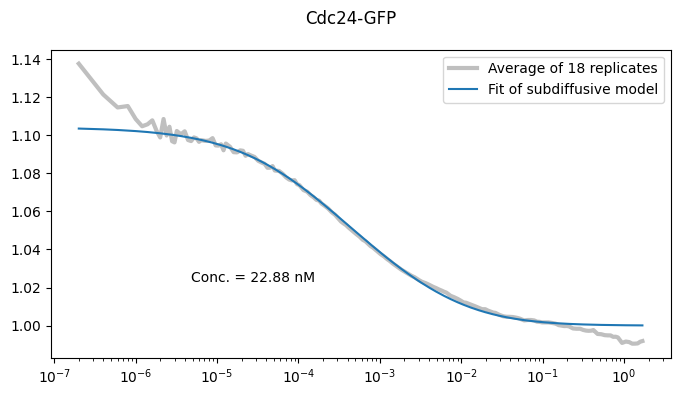

In [9]:
probe = Ap5
times_corr, mean_corr, n_total = get_corr(probe, clip=140) # clip at frame 140 such that autocorrelation persisting past 
popt, pcov = curve_fit(f_anomalousAp, times_corr[10:140], mean_corr[10:140], bounds=(0,100)) # Do not use extremely short-time AC for fit because this includes triplet state signal.
N = popt[0]
C = N/V
print(f"{probe[0][:3]} : {round(C, 3)} nM")
title = "Cdc24-GFP"
fig, axs = plt.subplots(1, 1, figsize=(8,4))#, dpi=600)
fig.suptitle(title)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_anomalousAp(times_corr, popt[0], popt[1]), 
         label=f"Fit of subdiffusive model")
axs.legend()
fig.text(.3,.3,s=f"Conc. = {round(C, 2)} nM")

/tmp/ipykernel_115190/601778994.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


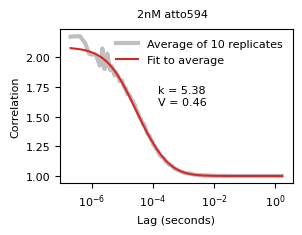

In [48]:
# Calibrate size of focal volume using concentration of atto594
atto10nM = 'atto596_2nM_0p2_fresh.fcs' # its actually 594
times_corr, mean_corr, n_total = get_corr(atto10nM, dir="../data/2024_10_11-fcs/")
fit = curve_fit(f_fitK, times_corr, mean_corr, p0=None)
popt, pcov = fit
title = f"2nM atto594"

fig, axs = plt.subplots(1, 1, figsize=(3,2))
fig.suptitle(title, fontsize=8)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_fitK(times_corr, *popt), 
         label="Fit to average", color="C03")
axs.legend(fontsize=8, frameon=False)
axs.set_ylabel("Correlation", fontsize=8)
axs.set_xlabel("Lag (seconds)", fontsize=8)
axs.tick_params(labelsize=8)
fig.text(.45,.5,s=f"k = {round(popt[2],2)} \nV = {round(popt[0]/2,2)}", fontsize=8)
plt.savefig("../figures/fit494.svg")
V = popt[0]/2

In [49]:
def get_countrate(files, dir="../data/2024_09_05-FCSandImg/"):
    '''
    Function to extract average count rate. Equivelent to relative intesntiy or brightness of the signal.
    Returns the avergae of all traces of all files provided. Uses only the first ~1/5 of the trace. 
    '''
    all_counts = []
    if type(files) != list:
        files = [files]
    for f in files:
        data = fcs.ConfoCor3Fcs(f'{dir}{f}')
        n_samp = len(data['FcsData']['FcsEntry'])
        for i in range(n_samp):
            counts = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CountRateArray'][:,1]
            all_counts.append(np.mean(counts[0:152])) # This should be the first 1 sec of a 5 sec trace. For atto488 it would be first 2 sec...
    return np.mean(all_counts)

In [50]:
def f_anomalousRed(tau, N, tauD):
    k = 5.38
    alpha = 0.68
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5

61.21868478749244 42242.23889802631
0.0014492291692984286 is factor for C per counts


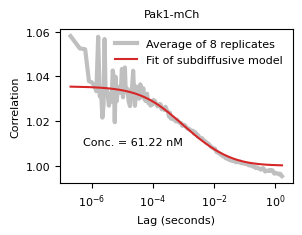

In [56]:
files = ["Pak1-mch-1.fcs"]
times_corr, mean_corr, n_total = get_corr(files, clip=140, dir="../data/2024_10_11-fcs/")
popt, pcov = curve_fit(f_anomalousRed, times_corr[10:140], mean_corr[10:140], bounds=(0,100))
counts = get_countrate(files, dir="../data/2024_10_11-fcs/")
N = popt[0]
C = N/V
print(C, counts)
print(f"{C/counts} is factor for C per counts")

title = "Pak1-mCh"
fig, axs = plt.subplots(1, 1, figsize=(3,2))
fig.suptitle(title, fontsize=8)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_anomalousRed(times_corr, *popt), 
         label=f"Fit of subdiffusive model", color="C03")
axs.legend(fontsize=8, frameon=False)
axs.set_ylabel("Correlation", fontsize=8)
axs.set_xlabel("Lag (seconds)", fontsize=8)
axs.tick_params(labelsize=8)
fig.text(.2,.3,s=f"Conc. = {round(C, 2)} nM", fontsize=8)

plt.savefig("../figures/FCS_Pak_mCh.svg")

76.33451085204167 42380.993800607284
0.0018011496193595126 is factor for C per counts


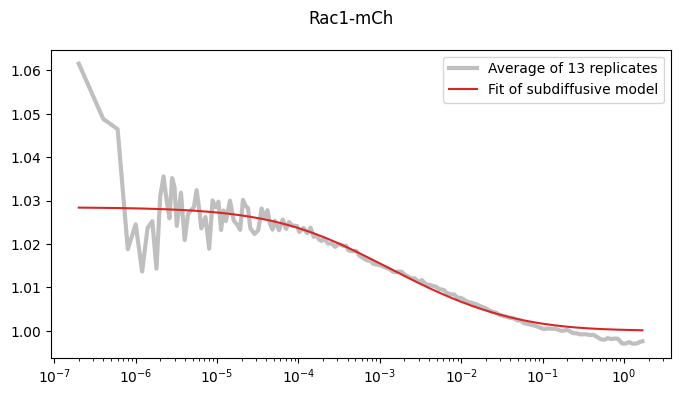

In [57]:
files = ["Rac1-mch-1.fcs"]
times_corr, mean_corr, n_total = get_corr(files, clip=140, dir="../data/2024_10_11-fcs/")
popt, pcov = curve_fit(f_anomalousRed, times_corr[10:140], mean_corr[10:140], bounds=(0,100))
counts = get_countrate(files, dir="../data/2024_10_11-fcs/")
N = popt[0]
C = N/V
print(C, counts)
print(f"{C/counts} is factor for C per counts")

title = "Rac1-mCh"
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(title)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_anomalousRed(times_corr, *popt), 
         label=f"Fit of subdiffusive model", color="C03")
axs.legend()